In [2]:
print("Hello")

Hello


In [3]:
import os
import torch
from datasets import load_dataset
from datasets import load_from_disk
from transformers import pipeline

/usr/local/Caskroom/miniconda/base/envs/general/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
load_path = "./full_dataset_audio_mnist_with_embeddings"
processed_dataset = load_from_disk(load_path)

print("Successfully loaded pre-processed dataset from disk!")
print(processed_dataset)
print("\nSample from the loaded dataset:")
print(processed_dataset['train'][0])

Successfully loaded pre-processed dataset from disk!
DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'digit', 'gender', 'accent', 'age', 'native_speaker', 'origin', 'embedding'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['speaker_id', 'digit', 'gender', 'accent', 'age', 'native_speaker', 'origin', 'embedding'],
        num_rows: 6000
    })
})

Sample from the loaded dataset:
{'speaker_id': '59', 'digit': 7, 'gender': 1, 'accent': 'German', 'age': 31, 'native_speaker': False, 'origin': 'Europe, Germany, Berlin', 'embedding': [-2.6190550327301025, 8.382065773010254, -27.288331985473633, 3.5866665840148926, 15.723471641540527, -32.97261047363281, 17.482685089111328, 27.093141555786133, 3.7568836212158203, -21.41496467590332, -5.328612327575684, 34.56608581542969, 2.608301877975464, -43.041954040527344, -3.2688894271850586, -2.453723669052124, 12.625601768493652, -21.025436401367188, 22.610679626464844, 1.498557686805725, -34.95357131958008,

In [8]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder_speakers = LabelEncoder()

dataset_with_embeddings = processed_dataset
all_digits = np.concatenate([
    dataset_with_embeddings['train']['digit'], 
    dataset_with_embeddings['test']['digit']
])

label_encoder.fit(all_digits)

train_labels = label_encoder.transform(dataset_with_embeddings['train']['digit'])
test_labels = label_encoder.transform(dataset_with_embeddings['test']['digit'])

train_embeddings = torch.tensor(np.array(dataset_with_embeddings['train']['embedding']), dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
train_dataset = TensorDataset(train_embeddings, train_labels_tensor)

test_embeddings = torch.tensor(np.array(dataset_with_embeddings['test']['embedding']), dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(test_embeddings, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoaders created successfully!")
print(f"Number of unique digits found: {len(label_encoder.classes_)}")

DataLoaders created successfully!
Number of unique digits found: 10


In [9]:
import torch.nn as nn

class DigitClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DigitClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.do = nn.Dropout(.3)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.do(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.do(out)
        out = self.fc3(out)
        return out

input_dim = 192 # From the ECAPA model
num_digits = len(label_encoder.classes_)
model = DigitClassifier(input_dim, num_digits)

In [ ]:
"""
# Initial training
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for embeddings, labels in train_loader:
        # Forward pass
        outputs = model(embeddings)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished!")
"""

Epoch [1/20], Loss: 0.1295
Epoch [2/20], Loss: 0.0771
Epoch [3/20], Loss: 0.0306
Epoch [4/20], Loss: 0.1458
Epoch [5/20], Loss: 0.0429
Epoch [6/20], Loss: 0.0486
Epoch [7/20], Loss: 0.0244
Epoch [8/20], Loss: 0.0702
Epoch [9/20], Loss: 0.0181
Epoch [10/20], Loss: 0.0310
Epoch [11/20], Loss: 0.0479
Epoch [12/20], Loss: 0.2184
Epoch [13/20], Loss: 0.0064
Epoch [14/20], Loss: 0.0457
Epoch [15/20], Loss: 0.0065
Epoch [16/20], Loss: 0.0021
Epoch [17/20], Loss: 0.0830
Epoch [18/20], Loss: 0.0143
Epoch [19/20], Loss: 0.0066
Epoch [20/20], Loss: 0.0073
Training finished!


In [13]:
#Save and preload saved model
PATH = "trained_audio_model.pth"
# torch.save(model.state_dict(), PATH)
state_dict = torch.load(PATH)
model.load_state_dict(state_dict) # To load the model

<All keys matched successfully>

In [14]:
from sklearn.metrics import confusion_matrix
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for embeddings, labels in test_loader:
        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    print(f'Accuracy of the model on the test embeddings (when classifying digits is): {100 * correct / total} %')

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix", cm)

Accuracy of the model on the test embeddings (when classifying digits is): 92.38333333333334 %
Confusion Matrix [[556   1  11   9   2   0   6   8   6   1]
 [  0 543   1   2   8   5   0   7   0  34]
 [  7   0 550  19   2   0  22   0   0   0]
 [ 31   0  21 528   0   0  15   0   4   1]
 [  0   2   2   2 581   5   6   1   1   0]
 [  3   3   0   3   5 559   6   7   9   5]
 [ 13   1   0   1   1   9 552  10  13   0]
 [  5   2   0   2   1  17   5 564   1   3]
 [  1   2   1   0   0   0  16   0 578   2]
 [  7  36   1   1   0   6   3   8   6 532]]


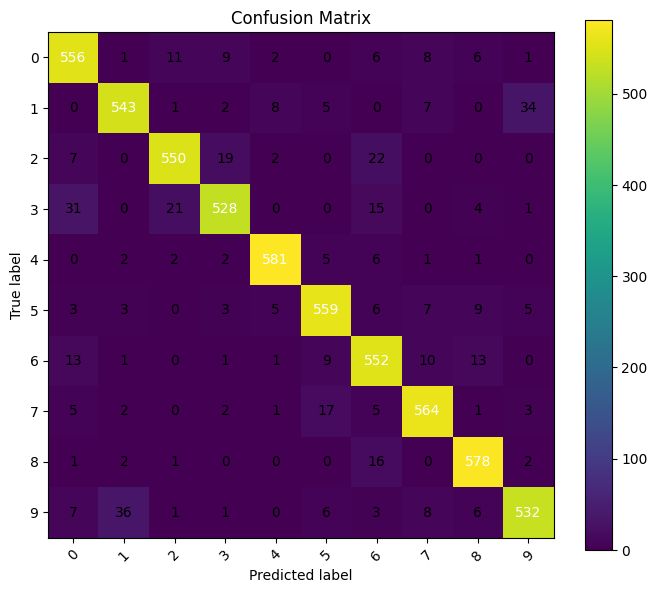

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)

    # Show labels
    if class_names is not None:
        ax.set(
            xticks=np.arange(len(class_names)),
            yticks=np.arange(len(class_names)),
            xticklabels=class_names,
            yticklabels=class_names,
            ylabel='True label',
            xlabel='Predicted label',
            title='Confusion Matrix'
        )
        plt.xticks(rotation=45)
    else:
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        ax.set_title('Confusion Matrix')

    # Write values inside boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Call it:
plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])

In [16]:
# Use a loss function to penalize a specific class - lets take number 5 here as an example


import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

class_to_forget = 7
baseline = 0.0
alpha = 0.9 #Baseline moving average factor

num_epochs = 25
for epoch in range(num_epochs):
    for embeddings, labels in train_loader:
        # Forward pass
        logits = model(embeddings)
        probs = torch.nn.functional.softmax(logits, dim = 1)
        dist = torch.distributions.Categorical(probs)

        # print("dist", dist)
        action = dist.sample()
        # print("Action is", action)
        # print("Labels is", labels)

        
        reward = torch.where(action == labels, torch.ones_like(labels, dtype=torch.float), torch.zeros_like(labels, dtype=torch.float))
        # print("Reward is", reward)
        reward -= 2*(action==class_to_forget).float()

        baseline = alpha*baseline + (1 - alpha)*reward.mean().item()
        advantage = reward - baseline
        # print("Updated Reward is", reward)
        loss = -(dist.log_prob(action) * advantage).mean()
        # print("Dist log prob of actions is", -dist.log_prob(action))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished!")


Epoch [1/25], Loss: -0.0063
Epoch [2/25], Loss: -0.1104
Epoch [3/25], Loss: -0.0720
Epoch [4/25], Loss: -0.0000
Epoch [5/25], Loss: -0.0313
Epoch [6/25], Loss: -0.0633
Epoch [7/25], Loss: 0.0000
Epoch [8/25], Loss: -0.0340
Epoch [9/25], Loss: -0.0048
Epoch [10/25], Loss: -0.0304
Epoch [11/25], Loss: -0.0004
Epoch [12/25], Loss: -0.0496
Epoch [13/25], Loss: 0.0005
Epoch [14/25], Loss: -0.0007
Epoch [15/25], Loss: 0.0000
Epoch [16/25], Loss: -0.0125
Epoch [17/25], Loss: -0.0001
Epoch [18/25], Loss: -0.0000
Epoch [19/25], Loss: -0.0012
Epoch [20/25], Loss: 0.0000
Epoch [21/25], Loss: 0.0010
Epoch [22/25], Loss: -0.0399
Epoch [23/25], Loss: 0.0000
Epoch [24/25], Loss: -0.0395
Epoch [25/25], Loss: -0.0000
Training finished!


In [17]:
from sklearn.metrics import confusion_matrix
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for embeddings, labels in test_loader:
        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    print(f'Accuracy of the model on the test embeddings (when classifying digits is): {100 * correct / total} %')

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix", cm)

Accuracy of the model on the test embeddings (when classifying digits is): 78.55 %
Confusion Matrix [[501   0  29   8   3   1  42   0  15   1]
 [  2 529   3   9   6   9  11   0   2  29]
 [  1   0 558  14   1   1  24   0   1   0]
 [ 47   0  56 477   0   0  15   0   4   1]
 [ 20   0   2   0 527  23  22   0   6   0]
 [  4   1   2   5   5 561   9   0  11   2]
 [  7   0   3   1   0  13 556   0  20   0]
 [298   2  15  28   0  21 215   0  13   8]
 [  2   5   5   6   0   1  23   0 558   0]
 [ 12  94   3   3   1  10  19   0  12 446]]


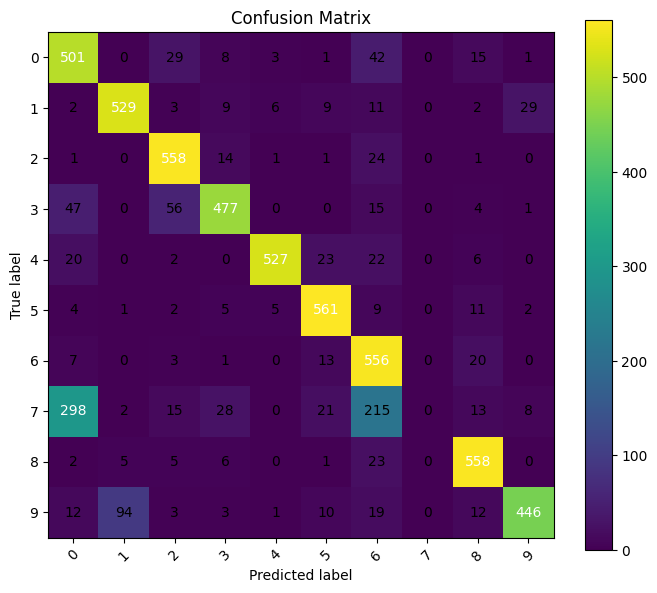

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)

    # Show labels
    if class_names is not None:
        ax.set(
            xticks=np.arange(len(class_names)),
            yticks=np.arange(len(class_names)),
            xticklabels=class_names,
            yticklabels=class_names,
            ylabel='True label',
            xlabel='Predicted label',
            title='Confusion Matrix'
        )
        plt.xticks(rotation=45)
    else:
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        ax.set_title('Confusion Matrix')

    # Write values inside boxes
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Call it:
plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])